In [1]:
import os

In [2]:
os.chdir('..')

## Compiling

If all the required libraries are installed and the paths had been adjusted in the Makefile, one should be able to build the code.

If one simple executes `make` or `make help`, there is a brief summary of which components can be built.

In [16]:
%%bash

make 

---------------------
 Magnetizer Makefile
---------------------
  make prod -> Builds main program for a production run.
  make test -> Builds main program for a test run (debugging and backtracing enabled).
  make Observables -> Builds the Observables.exe excecutable, which computes polarized and total synchrotron intensity, as well as rotation measures, and includes them in the output.
  make Observables_single -> Builds the Observables_single.exe excecutable, which computes line-of-sight quantities for individual galaxies in the output.
  make clean -> Removes all object files.
  make cleanall -> Removes all object files, executables files and python bytecode.
  make all -> Builds all test programs and main program (test settings).
  make help -> Displays this help


We strongly recommend initially using `make test` for compiling the `Magnetizer`. The `make prod` option enables the compiler optimizations and *disables* debugging and backtracing features. Also, when major changes are made to the source, it often a good idea to use the `make cleanall` command to avoid problems.

In [17]:
%%bash 

make test


Building Magnetizer test/debug run

h5pfc build/tsDataObj.o build/bessel_functions.o build/root_finder.o build/constants.o build/grid.o build/floor_field.o build/global_input_parameters.o build/surface_density.o build/pressureEquilibrium.o build/outflow.o build/random.o build/input_parameters.o build/IO_hdf5.o build/profiles.o build/gutsdynamo.o build/ts_arrays.o build/data_transfer.o build/output.o build/dynamo.o build/rotationCurves.o build/deriv.o build/messages.o build/interpolation.o build/integration.o build/seed_field.o build/distributor.o build/Magnetizer.o -I /usr/local/include/fgsl/ -lfgsl -I. -I./source/ -J./build/ -fintrinsic-modules-path ./build -I./build/ -I/usr/include/  -fbacktrace  -ffpe-trap=zero,invalid,overflow -fbounds-check -lgsl -lgslcblas -lm -g -Wall -o Magnetizer.exe


This should have generated the `Magnetizer.exe` executable file in the current working directory.

## Preparing an input file

The Magnetizer code relies on two things in order to run: a **parameters file** and an **input file**. The *parameters file* contains all the setup associated with a run particular run. For example, it contains the path to the input and output files, the number of grid points to be used for the profiles, which assumptions should be used for solving the dynamo equations, etc. We will discuss this in another section.

The *input file* contains the properties of the galaxies for which the Magentizer will compute the ISM and magnetic properties.  This file can be generated from a Galform `galaxies.hdf5` output file using the python script `python/prepare_input.py`, which contains some usage information:

In [20]:
%%bash

./python/prepare_input.py -h

usage: prepare_input.py [-h] [-n NUMBER_OF_GALAXIES]
                        [-nz NUMBER_OF_EXTRA_GALAXIES_PER_Z]
                        [-BoT MAXIMUM_B_OVER_T] [-ms MINIMUM_STELLAR_MASS]
                        [-mg MINIMUM_GAS_MASS] [-Ms MAXIMUM_STELLAR_MASS]
                        [-r MINIMUM_DISK_SIZE] [-z MAX_REDSHIFT] [-naz]
                        SAM_OUTPUT MAGNETIZER_INPUT

Prepares an input file for the Magnetizer.

positional arguments:
  SAM_OUTPUT            HDF5 output file of a Galform run.
  MAGNETIZER_INPUT      Name of the Magnetizer input file to be prepared.

optional arguments:
  -h, --help            show this help message and exit
  -n NUMBER_OF_GALAXIES, --number_of_galaxies NUMBER_OF_GALAXIES
                        Approximate *maximum* number of galaxies to extract
                        from the SAM_OUTPUT file at z=0. The evolution of
                        these galaxies will then be followed.Default: 1e10.
  -nz NUMBER_OF_EXTRA_GALAXIES_PER_Z, --numbe

Here I provide a brief description of what is been done by this script.

The script will start looking at the output at $z=0$, select the specified number of galaxies. For each galaxy, it step on the merger tree towards higher redshift, always choosing the most massive progenitor brach. Thus, this procedures *converts the original merger tree to a simple time series*, i.e. each galaxy is represented by a time series of properties (instead of a graph).

The sample obtained until now is biased: for $z>0$, only the most massive galaxies of each merger tree is being selected. To avoid this, the script moves to the next available redshift and repeats the procedure (skipping galaxies which had been previously stored). Suppose, for definitness that this next redshift is $z=0.01$, the script will look at a number NUMBER_OF_EXTRA_GALAXIES_PER_Z galaxies at $z=0.01$ that were not picked before. For each of these, it will store their properties of the galaxies and move to the most massive branch. Again, a time series will be generated, but it will end at $z=0.01$ instead of $z=0$, because this galaxies merge (or cease to satisfy the selecton criteria) after this redshit. The absent $z=0$ data is signalled in the input file as -999999 marker (which is ignored both by the Magnetizer programs and the python library).
The procedure then continues analogously for other redshits.

The seclection criteria (e.g. MINIMUM_DISK_SIZE) are applied on the redshift where the galaxies are first sampled *but not on the progenitors of the galaxies* (but note that the progenitors *do appear in the sample*).  To make things concrete, suppose we choose to sample 10 galaxies with disk size greater than 10 kpc. The script will look at $z=0$, try to find 10 galaxies with $r_\mathrm{disk}>10\,\mathrm{kpc}$ , and include those galaxies and all their (most massive) progenitors at $z>0$, even if the progenitors have $r_\mathrm{disk}<10\,\mathrm{kpc}$. The reason for this is that, for any sampled galaxy, we want to have access the full history of the galaxy in its time series, so that the Magnetizer can solve the dynamo equations.  To avoid mixing galaxies which are actually sampled with galaxies which are in the sample simply because they are progenitors of sampled galaxies, one can use the "sample_z" property.  A very brute-force and computationally intensive (but often useful) alternative, is to simply use all the galaxies in a given Galform's output, and leave any selection for the analysis step (this is what has actually been done in published work).

An example call to this script (with no filtering) would look like:
```console
./python/prepare_input.py /data/Galform/Lace16/ivol0/galaxies.hdf5 /data/magnetizer_inputs/Lacey16_input.hdf5 
```

*Note: the earlier published results of the Magnetizer project used input files where the galactic disk radii were rescaled so that the median of distribution of radii
at a given mass bin would match the observed relation found by Lange et al 2016 (for more details, please contact Luiz Felippe). This procedure is exemplified for the Lacey 2016 model in the figure below (the blue band corresponds to the interval between the 25th and 75th percentiles in the original output, and red is the corrected version. The second panel show the correction factor which was applied.*

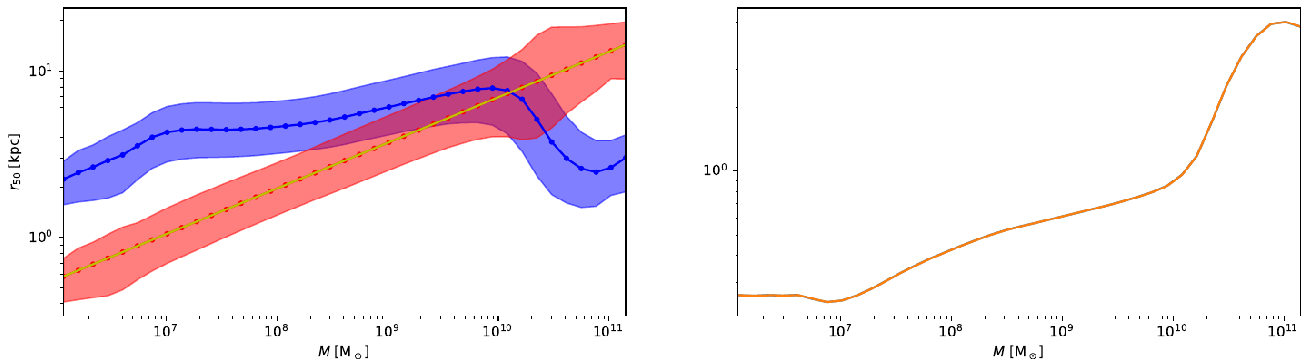


## Parameters file

The input parameters files for a Magnetizer run use Fortran namelists. 
Any parameter skipped in a namelist is set to its default value. 
Thus, an example of a minimal working parameter file would be:

```fortran
&run_parameters  
   model_name = "My run"
   info = 2
/
&io_parameters
  input_file_name = "my_input.hdf5"
  output_file_name = "my_output.hdf5"
  output_quantities_list = 'Bmax'
/
&grid_parameters  
/
&dynamo_parameters
/
&ISM_and_disk_parameters  
/
&outflow_parameters  
/
&observables_parameters 
/
```

The best place to find a description of each parameter and its default values is the file [global_input_parameters.f90](../source/global_input_parameters.f90), 
which is where the namelists and global parameters are defined. This file is heavily documented (and should be kept so!) so that the usage of each specific 
parameter should be clear (if something is not clear, please contact us).

After a magnetizer run, the parameters are *stored in the output hdf5 file*, to facilitate archival and avoid future confusion.

## Running the Magnetizer

In [18]:
import sys
sys.path.append('python')
import magnetizer